<a href="https://colab.research.google.com/github/mattia-dalta/Airplane-disasters/blob/main/Airplane_disaster_(1919_2023).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction
This analysis was conducted for the International Alliance for Safe Skies (IASS) and aims to explore and extract insights from aviation accidents occurring worldwide from 1919 to 2023.

In [1]:
#Importing external libraries and Python standard modules used in the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.express as px
import seaborn as sns
import re
import os

#Data loading and cleaning

In [2]:
#Import of the dataset aviation-accidents.csv from git-hub link and load

# File path
url = 'https://raw.githubusercontent.com/mattia-dalta/Airplane-disasters/refs/heads/main/aviation-accidents.csv'

# Loading the file
df = pd.read_csv(url)

# Showing the first rows of dataset
df.head()

,date,type,registration,operator,fatalities,location,country,cat,year
0,date unk.,Antonov An-12B,T-1206,Indonesian AF,NaN,NaN,Unknown country,U1,unknown
1,date unk.,Antonov An-12B,T-1204,Indonesian AF,NaN,NaN,Unknown country,U1,unknown
2,date unk.,Antonov An-12B,T-1201,Indonesian AF,NaN,NaN,Unknown country,U1,unknown
3,date unk.,Antonov An-12BK,NaN,Soviet AF,NaN,Tiksi Airport (IKS),Russia,A1,unknown
4,date unk.,Antonov An-12BP,CCCP-11815,Soviet AF,0,Massawa Airport ...,Eritrea,A1,unknown


In [3]:
# Show basic info about columns and types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23967 entries, 0 to 23966
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          23967 non-null  object
 1   type          23967 non-null  object
 2   registration  22419 non-null  object
 3   operator      23963 non-null  object
 4   fatalities    20029 non-null  object
 5   location      23019 non-null  object
 6   country       23967 non-null  object
 7   cat           23967 non-null  object
 8   year          23967 non-null  object
dtypes: object(9)
memory usage: 1.6+ MB


The format of the column are object. We need to change it.

In [4]:
# Count missing values per column
df.isnull().sum()

,0
date,0
type,0
registration,1548
operator,4
fatalities,3938
location,948
country,0
cat,0
year,0


##Management of NaN value

The dataset contains a significant number of missing values (NaN). Additionally, some cells do not explicitly contain NaN, but the text within them clearly indicates that the information is missing or unusable (e.g., 'unknown', 'date unk', '-', '?'). Therefore, the goal is to clean the dataset by removing or handling missing values and applying a regular expression to standardize and convert all such placeholder values into proper NaNs, making the dataset more suitable for analysis.

In [5]:

missing_patterns = {
    r'(?i)^unknown$': np.nan,     # Matches "unknown" (case-insensitive)
    r'(?i)^unk$': np.nan,         # Matches "unk" (case-insensitive)
    r'(?i)^date unk\.?$': np.nan, # Matches "date unk." or "date unk" (case-insensitive, optional dot)
    r'(?i)^n/?a$': np.nan,        # Matches "n/a" or "na" (case-insensitive, optional slash)
    r'(?i)^null$': np.nan,        # Matches "null" (case-insensitive)
    r'(?i)^none$': np.nan,        # Matches "none" (case-insensitive)
    r'^\s*$': np.nan,             # Matches empty strings or strings with only whitespace
    r'^-$': np.nan,               # Matches a single dash "-"
    r'^\?$': np.nan               # Matches a single question mark "?"
}

# Replace all values in the DataFrame 'df' that match any of the above regex patterns with np.nan.


df.replace(missing_patterns, regex=True, inplace=True)



## Data Cleaning – Operations After Missing Value Standardization

After standardizing missing values using regular expressions, additional cleaning steps were performed on specific columns to further improve the dataset’s quality and analytical value.

The first intervention involved the `country` and `location` columns, which are often used for aggregation and visualization purposes. Since both columns still contained missing values after the initial cleanup, it was decided to replace all remaining missing entries with the label `"Unknown"`. This approach ensures that no records are excluded from groupings or plots and provides a consistent placeholder that maintains the interpretability of the data.

The focus then shifted to the `date` column, which originally contained textual representations of dates, often in inconsistent or incomplete formats. These were converted into a standardized datetime format. In cases where the date was missing but the year was available, a default placeholder date—January 1st of the reported year—was assigned. This imputation strategy ensured that each observation retained a usable temporal reference, which is crucial for any chronological or trend-based analysis.

The `registration` column was removed entirely from the dataset. This variable was deemed non-essential for the planned analyses and removing it helped streamline the dataset, improving both clarity and performance.

Finally, data type harmonization was carried out to ensure consistency across columns. Textual variables such as `country`, `operator`, and `type` were converted to string format, ensuring proper handling of missing values and uniform string processing. The `cat` column, representing a categorical variable, was converted to a categorical type to optimize memory usage and support more efficient grouping operations. Numerical columns such as `fatalities` and `year`, which could contain missing values, were converted to nullable integer types, allowing them to retain `NaN` values while maintaining numerical integrity.

Together, these operations completed the structural cleaning process, resulting in a dataset that is coherent, reliable, and ready for further analysis and visualization.

In [6]:
# 3. Fill missing values in categorical columns with 'Unknown'
categorical_columns = ['country', 'operator', 'type', 'cat']
for col in categorical_columns:
    df.loc[:, col] = df[col].fillna('Unknown')



In [7]:
# Function to safely evaluate numerical expressions in string format (e.g., '1+3', '2+2+1')
# Some entries in the 'fatalities' column are not simple integers but string-based arithmetic expressions.
# This function checks if the input string contains only allowed characters (digits, +, -, *, /, ., parentheses),
# and then uses `eval()` to compute the result.
# For other valid numeric values, it uses `pd.to_numeric`; otherwise, it returns NaN.

def safe_eval(expr):
    try:

        if isinstance(expr, str) and all(c in "0123456789+-*/(). " for c in expr):
            return eval(expr)
        else:
            return pd.to_numeric(expr, errors='coerce')
    except:
        return np.nan

In [8]:
# 1. Convert 'date' column to datetime format
# If parsing fails, result is set to NaT
df['date'] = pd.to_datetime(df['date'], errors='coerce', format='%d-%b-%Y')

In [9]:
# 2. Replace missing 'date' values with '01 Jan <year>' if 'year' is available
mask_missing_date = df['date'].isna() & df['year'].notna()
df.loc[mask_missing_date, 'date'] = pd.to_datetime(
    df.loc[mask_missing_date, 'year'].astype(int).astype(str) + '-01-01'
)

In [10]:
df.head(100)

,date,type,registration,operator,fatalities,location,country,cat,year
0,NaT,Antonov An-12B,T-1206,Indonesian AF,NaN,NaN,Unknown country,U1,NaN
1,NaT,Antonov An-12B,T-1204,Indonesian AF,NaN,NaN,Unknown country,U1,NaN
2,NaT,Antonov An-12B,T-1201,Indonesian AF,NaN,NaN,Unknown country,U1,NaN
3,NaT,Antonov An-12BK,NaN,Soviet AF,NaN,Tiksi Airport (IKS),Russia,A1,NaN
4,NaT,Antonov An-12BP,CCCP-11815,Soviet AF,0,Massawa Airport ...,Eritrea,A1,NaN
...,...,...,...,...,...,...,...,...,...
95,1927-08-22,Fokker F.VIII,H-NADU,KLM,1,"St. Julians, Sev...",U.K.,A1,1927
96,1928-02-15,Handley Page W.8b,G-EBBG,Imperial Airways,0,near Abbeville,France,A1,1928
97,1928-03-11,Farman F.60 Goliath,F-AEFC,Air Union,2,"near Folkestone, Kent...",U.K.,A1,1928
98,1928-04-11,Fokker F.VIII,H-NAEE,KLM,0,Nigtevecht,Netherlands,A1,1928


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23967 entries, 0 to 23966
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          23906 non-null  datetime64[ns]
 1   type          23967 non-null  object        
 2   registration  22408 non-null  object        
 3   operator      23967 non-null  object        
 4   fatalities    20029 non-null  object        
 5   location      22703 non-null  object        
 6   country       23967 non-null  object        
 7   cat           23967 non-null  object        
 8   year          23906 non-null  object        
dtypes: datetime64[ns](1), object(8)
memory usage: 1.6+ MB


In [12]:
df.describe()

,date
count,23906
mean,1974-04-20 23:10:54.463314720
min,1919-08-02 00:00:00
25%,1948-09-06 06:00:00
50%,1971-12-30 00:00:00
75%,1995-08-14 18:00:00
max,2023-05-15 00:00:00


In [13]:
df = df.copy()

In [14]:
# Convert textual columns to string
df['country'] = df['country'].astype('string')
df['operator'] = df['operator'].astype('string')
df['type'] = df['type'].astype('string')

# Convert categorical column to category
df['cat'] = df['cat'].astype('category')

# Convert 'fatalities' to numeric, allowing NaN
df['fatalities'] = pd.to_numeric(df['fatalities'], errors='coerce')
df['fatalities'] = df['fatalities'].astype('Int64')


# Convert 'year' to nullable integer (Int64)
df['year'] = df['year'].astype('Int64')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23967 entries, 0 to 23966
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          23906 non-null  datetime64[ns]
 1   type          23967 non-null  string        
 2   registration  22408 non-null  object        
 3   operator      23967 non-null  string        
 4   fatalities    19676 non-null  Int64         
 5   location      22703 non-null  object        
 6   country       23967 non-null  string        
 7   cat           23967 non-null  category      
 8   year          23906 non-null  Int64         
dtypes: Int64(2), category(1), datetime64[ns](1), object(2), string(3)
memory usage: 1.5+ MB


In [16]:
# Show updated missing values per column
df.isnull().sum()

,0
date,61
type,0
registration,1559
operator,0
fatalities,4291
location,1264
country,0
cat,0
year,61


In [17]:
# Drop the 'registration' column from the DataFrame, it doesn't give informations
df.drop(columns='registration', inplace=True)

#Exploratory Insights

## Anomalous Day: May 10, 1940


During the exploratory data analysis, one particular date stood out: **May 10, 1940**, which recorded an **exceptionally high number of aviation accidents** — over **170 incidents** on that single day. This figure is significantly higher than any other day in the dataset.

Upon further inspection, most of the incidents involved **Junkers Ju-52/3m aircraft** operated by the **German Air Force**, with a geographic concentration in the **Netherlands and Belgium**.

This spike is not random. **May 10, 1940** marks the beginning of **Germany's invasion of Western Europe** during World War II, with coordinated attacks on France, Belgium, and the Netherlands. The high number of aircraft losses is likely linked to **military operations**, such as **troop deployments, bombings, or aerial combat**.

> While this anomaly is historically accurate, it may distort trend analyses or statistical models. For this reason, it's important to **flag it clearly** and, if necessary, **treat it separately** from civil or evenly distributed events in the dataset.


In [18]:
date_counts = df['date'].value_counts().sort_values(ascending=False)

print("Top 10 most frequent dates in the dataset:")
print(date_counts.head(10))

Top 10 most frequent dates in the dataset:
date
1940-05-10    171
1945-03-24     50
1944-06-06     41
1944-09-17     35
1944-09-18     29
1944-09-19     28
1944-09-21     26
1945-01-01     26
1941-12-07     23
1941-01-01     23
Name: count, dtype: int64


In [19]:
df[df['date'] == '1940-05-10']

,date,type,operator,fatalities,location,country,cat,year
562,1940-05-10,Junkers Ju-52/3m,German AF,<NA>,Waalhaven,Netherlands,A1,1940
563,1940-05-10,Junkers Ju-52/3m,German AF,<NA>,Valkenburg,Netherlands,A1,1940
564,1940-05-10,Junkers Ju-52/3m,German AF,<NA>,'s Gravenzande,Netherlands,A1,1940
565,1940-05-10,Junkers Ju-52/3m,German AF,<NA>,NaN,Netherlands,A1,1940
566,1940-05-10,Junkers Ju-52/3m,German AF,<NA>,Maassluis,Netherlands,A1,1940
...,...,...,...,...,...,...,...,...
728,1940-05-10,Junkers Ju-52/3m,German AF,<NA>,Waalhaven,Netherlands,A1,1940
729,1940-05-10,Junkers Ju-52/3m,German AF,<NA>,Waalhaven,Netherlands,A1,1940
730,1940-05-10,Junkers Ju-52/3m,German AF,<NA>,Druten,Netherlands,A1,1940
731,1940-05-10,Junkers Ju-52/3m,German AF,<NA>,Rozenburg,Netherlands,A1,1940


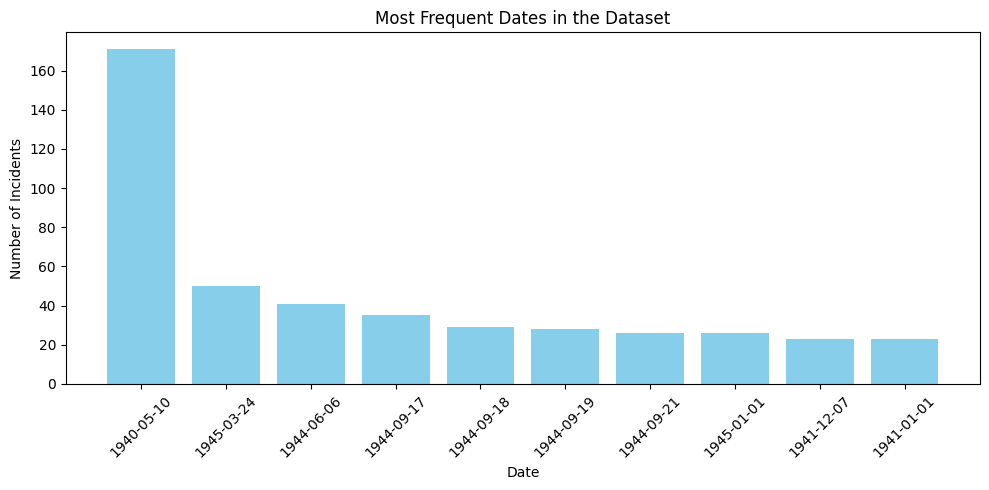

In [20]:
top_dates = date_counts.head(10).reset_index()
top_dates.columns = ['date', 'incident_count']


plt.figure(figsize=(10, 5))
plt.bar(top_dates['date'].astype(str), top_dates['incident_count'], color='skyblue')
plt.xticks(rotation=45)
plt.title('Most Frequent Dates in the Dataset')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.tight_layout()
plt.show()

##Which countries had the highest number of aviation accidents?
This chart highlights the countries with the highest number of aviation accidents. Note that the frequency may be influenced not only by safety records, but also by factors such as air traffic volume, data completeness, and reporting standards.

In [21]:
# Set up the visual configuration for all plots:
# - Use Seaborn's 'whitegrid' style for better readability and cleaner backgrounds.
# - Set default figure size to 12x6 inches to improve visibility of plots.

# Set visual style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


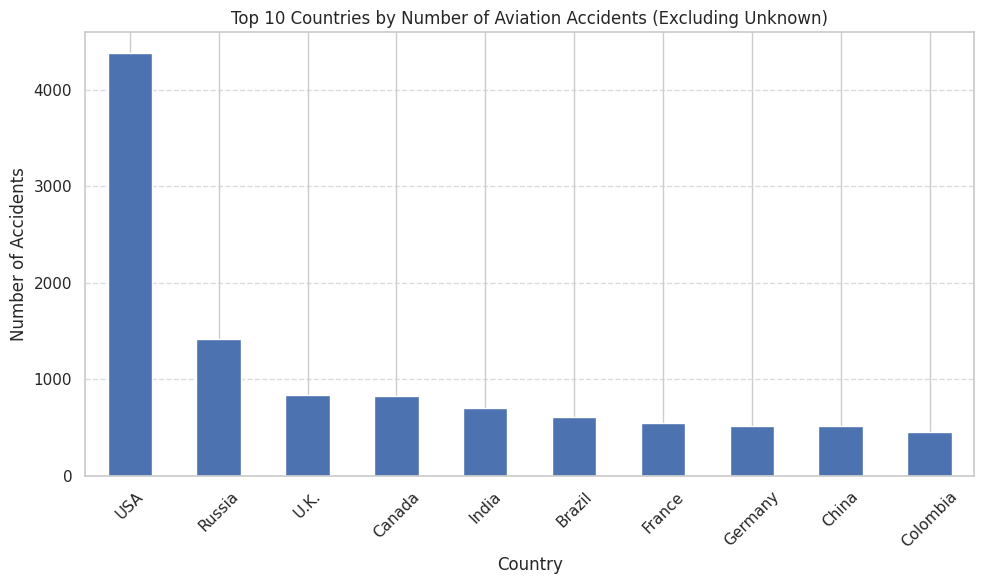

In [22]:
# Exclude all values that contain 'unknown' (case insensitive)
df = df[~df['country'].str.lower().str.contains('unknown', na=False)] #this line of code exclude the categories of Uknown countries (~ = non uknown)

# Count top 10 countries
country_counts = df['country'].value_counts().head(10)


plt.figure(figsize=(10,6))
country_counts.plot(kind='bar')
plt.title('Top 10 Countries by Number of Aviation Accidents (Excluding Unknown)')
plt.xlabel('Country')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



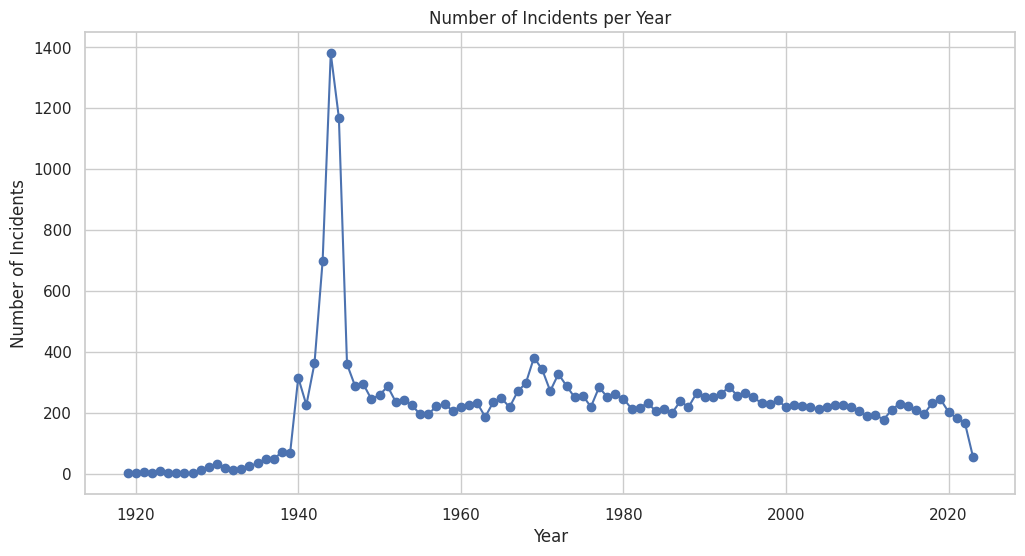

In [23]:
yearly_incidents = df['year'].value_counts().sort_index()
yearly_incidents.plot(kind='line', marker='o')
plt.title('Number of Incidents per Year')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.grid(True)
plt.show()


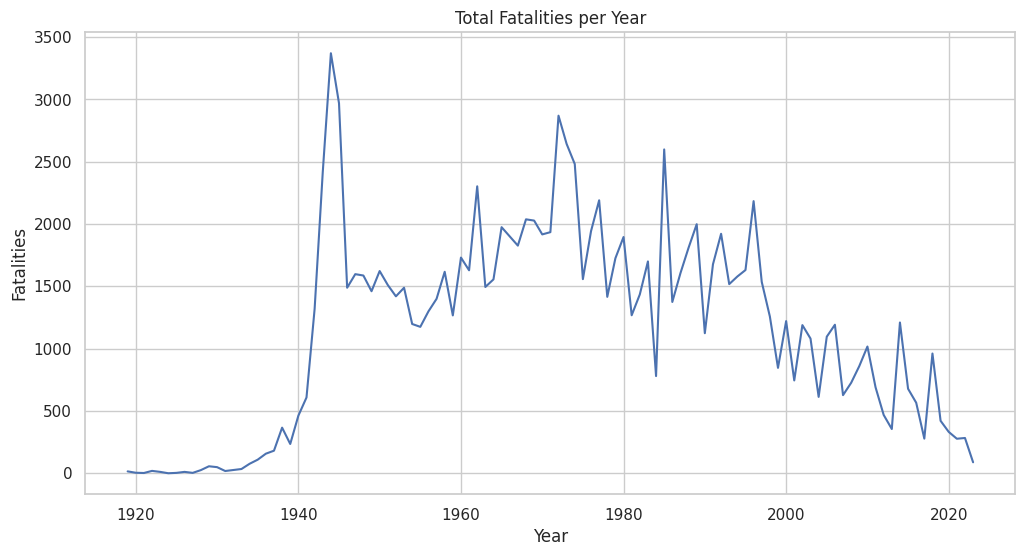

In [24]:
df_by_year = df.groupby('year')['fatalities'].sum().dropna()

df_by_year.plot(kind='line')
plt.title('Total Fatalities per Year')
plt.xlabel('Year')
plt.ylabel('Fatalities')
plt.grid(True)
plt.show()


> **Note:**  
> - The sharp increase in aviation accidents between 1940 and 1945 is likely related to World War II.  
>   During this period, military operations intensified globally, leading to a significantly higher volume of flights, increased risk exposure, and a greater number of aircraft incidents.  
> - The low number of recorded accidents from 1920 to 1930s is probably due to the limited use of aircraft at the time and the possible lack of reliable records or data collection in those years.
Also the trend fatalities seems to follow the curve of number of incidents.


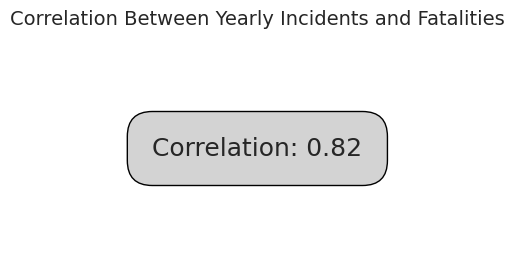

In [25]:
# Calculate the number of incidents and total fatalities per year
yearly_stats = df.groupby(df['date'].dt.year).agg(
    incidents=('fatalities', 'count'),    # number of incidents per year (non-null fatality entries)
    fatalities=('fatalities', 'sum')      # total number of fatalities per year
).dropna().reset_index()

# Compute the correlation between annual incidents and fatalities
cor_value = yearly_stats['fatalities'].corr(yearly_stats['incidents'])



plt.figure(figsize=(5, 3))
plt.text(0.5, 0.5, f'Correlation: {cor_value:.2f}',
         fontsize=18, ha='center', va='center',
         bbox=dict(facecolor='lightgrey', edgecolor='black', boxstyle='round,pad=1'))
plt.axis('off')
plt.title('Correlation Between Yearly Incidents and Fatalities', fontsize=14)
plt.show()




##Correlation Between Incidents and Fatalities
It is reasonable to expect a positive correlation between the number of incidents and fatalities over the years. This is confirmed by the Pearson correlation coefficient of 0.69, indicating a strong relationship: as the number of aviation accidents increases, so does the number of fatalities.
This result is intuitive, more incidents generally imply greater exposure to risk, and therefore, a higher likelihood of casualties.

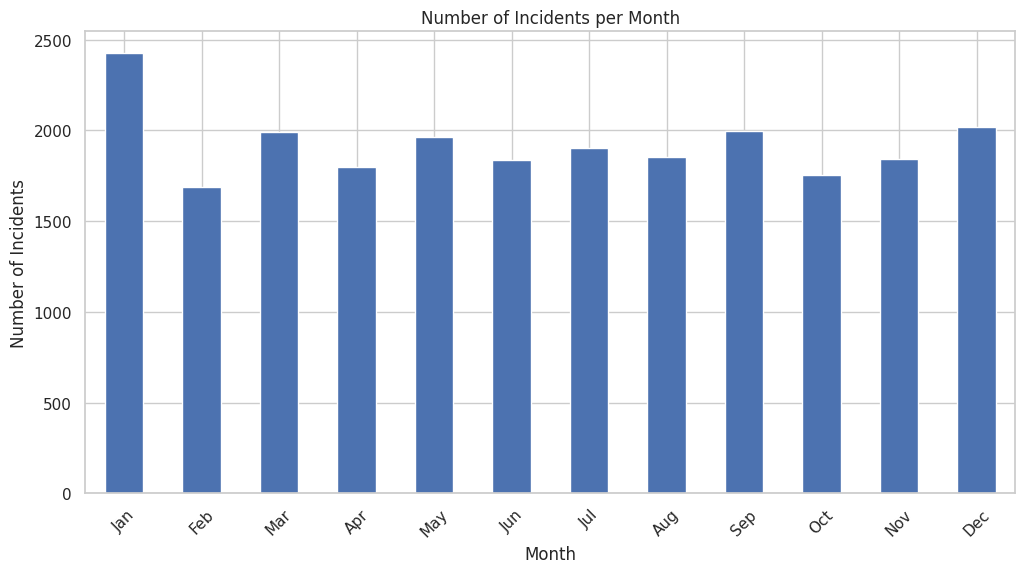

In [26]:
monthly_incidents = df['date'].dt.month.value_counts().sort_index()
monthly_incidents.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                           'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_incidents.plot(kind='bar')
plt.title('Number of Incidents per Month')
plt.xlabel('Month')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.show()

In [27]:
# Check how many incidents are exactly on January 1st
df['is_jan_1'] = (df['date'].dt.month == 1) & (df['date'].dt.day == 1)
jan1_counts = df['is_jan_1'].sum()
print(f"Incidents recorded on January 1st: {jan1_counts}")

# Total incidents in January (any day)
total_jan = (df['date'].dt.month == 1).sum()
print(f"Total incidents in January: {total_jan}")

Incidents recorded on January 1st: 445
Total incidents in January: 2425


An unusually high number of aviation incidents appear to be concentrated in January. Upon closer inspection, this spike is largely artificial. In the preprocessing phase, when the exact date was missing but the year was available, a default date of January 1st of the given year was used for imputation. This approach, while preserving the temporal dimension of the record, has unintentionally inflated the count of incidents reported in early January. This highlights the importance of transparency and caution in handling missing date values, as default imputations can generate misleading seasonal patterns in the data.

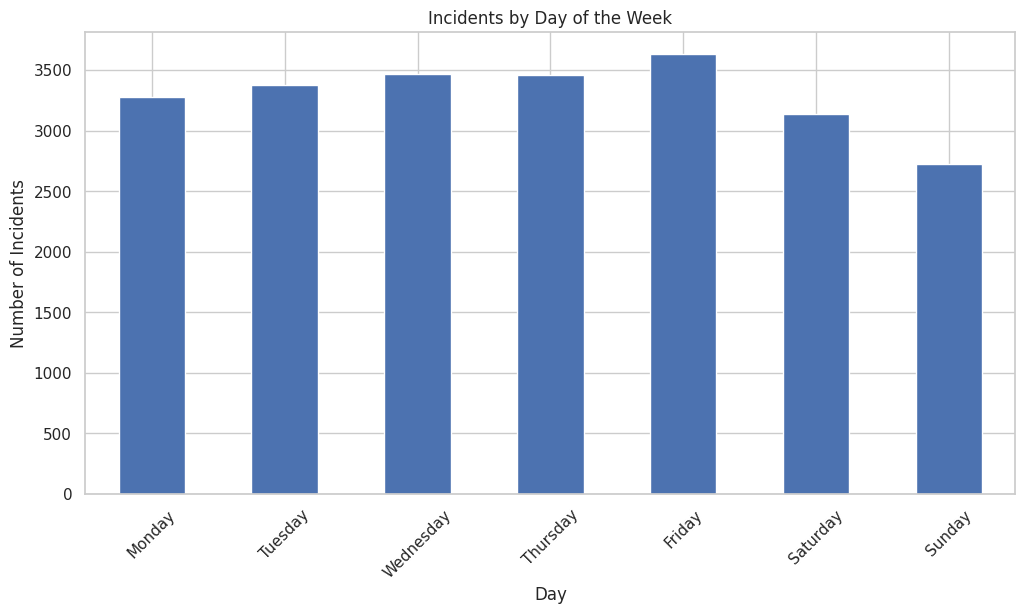

In [28]:
df['weekday'] = df['date'].dt.day_name()
dow_counts = df['weekday'].value_counts().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

dow_counts.plot(kind='bar')
plt.title('Incidents by Day of the Week')
plt.xlabel('Day')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.show()

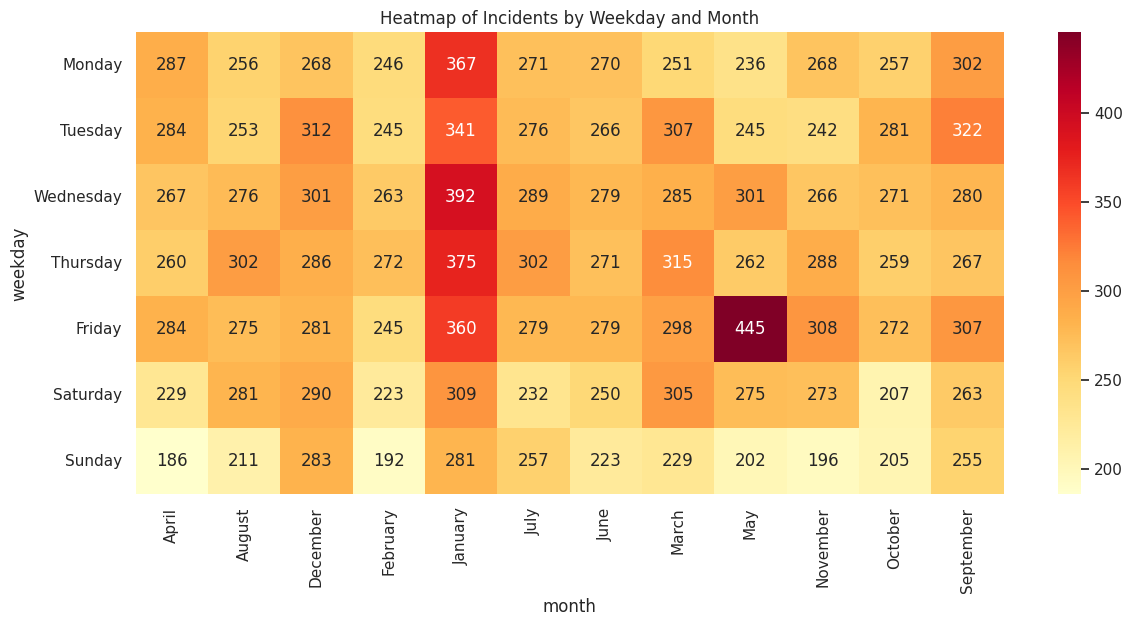

In [29]:

df['month'] = df['date'].dt.month_name()

pivot = df.pivot_table(index='weekday', columns='month', values='date', aggfunc='count')


ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot = pivot.reindex(ordered_days)

plt.figure(figsize=(14, 6))
sns.heatmap(pivot, cmap='YlOrRd', annot=True, fmt='.0f')
plt.title('Heatmap of Incidents by Weekday and Month')
plt.show()


There is no clear evidence of a strong correlation between the number of incidents and specific days of the week or months of the year. While the heatmap suggests a higher number of incidents on Fridays and particularly in the month of May, these patterns should be interpreted with caution. The observed concentration may be due to random variation or specific isolated events, and cannot be considered statistically significant without further inferential analysis.

Additionally, a noticeable spike in incidents is recorded in January. This anomaly is likely explained by the data imputation process: when the exact date of an incident was missing but the year was known, a default date of January 1st was assigned. This approach, while preserving the temporal structure, artificially inflates the number of incidents reported in January.

To confirm whether the visual trends observed are meaningful, further analysis using inferential statistical methods — such as hypothesis testing or time series modeling — would be necessary.



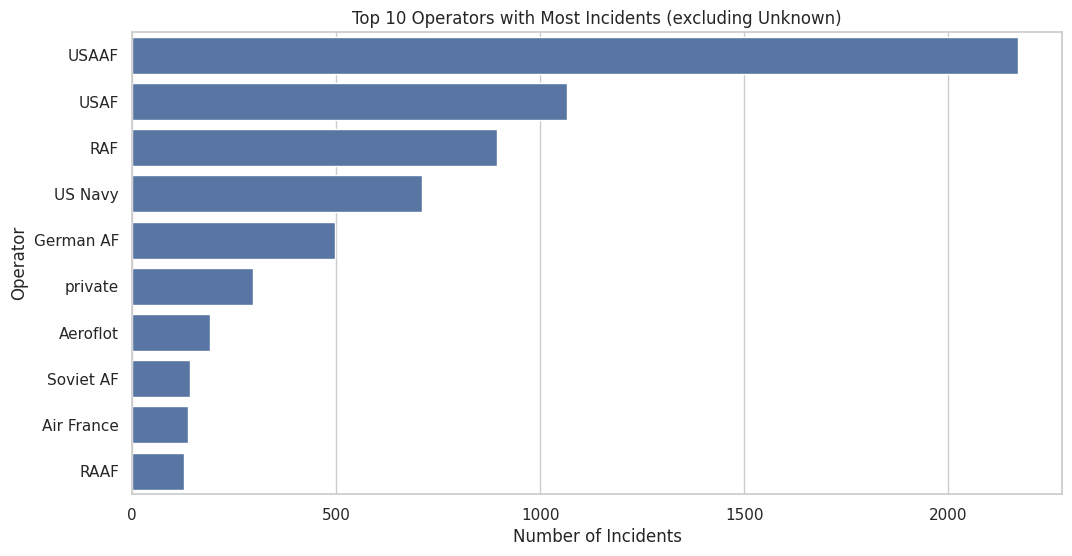

In [30]:
# Remove 'Unknown' or similar from operator column
filtered_df = df[~df['operator'].str.lower().str.contains('unknown', na=False)]

# Top 10 operators with most incidents
top_operators = filtered_df['operator'].value_counts().head(10)

# Plot
sns.barplot(x=top_operators.values, y=top_operators.index)
plt.title('Top 10 Operators with Most Incidents (excluding Unknown)')
plt.xlabel('Number of Incidents')
plt.ylabel('Operator')
plt.show()



**Note:**  
The chart includes both *USAAF* (United States Army Air Forces) and *USAF* (United States Air Force).  
These are historically distinct entities: the USAAF was active until 1947, after which it became the independent USAF.  
Their presence among the top operators reflects both military aviation activity and comprehensive reporting over time.


### Why Are Most Incidents Associated with American Operators?

The fact that many incidents involve American operators doesn’t necessarily mean they’re less safe. It mostly comes down to the size and reach of the U.S. aviation industry, especially throughout the 20th century.

A few reasons explain this:

More flights: The U.S. has had one of the busiest commercial and military aviation networks in the world, so more incidents are naturally expected.

Better records: U.S. authorities have kept detailed records for decades, which makes the data more complete.

Wider presence: American airlines and military forces have operated globally, which increases their exposure to risk.

So the numbers are more about scale and documentation than poor safety.

In [31]:


top_types = df['type'].value_counts().nlargest(20)
df_treemap = df[df['type'].isin(top_types.index)]

fig = px.treemap(df_treemap, path=['type'], values='fatalities',
                 title='Fatalities by Aircraft Type')
fig.show()

The Douglas C-47, also known as the Dakota in its military version, appears frequently in the dataset because it was one of the most widely used aircraft in history, especially during and after World War II.

In [32]:


# Group by operator and calculate total number of incidents and fatalities
operator_stats = df.groupby('operator').agg(
    incident_count=('operator', 'count'),
    total_fatalities=('fatalities', 'sum')
).reset_index()

# Select the top 20 operators with the highest number of incidents
top_operators = operator_stats.sort_values(by='incident_count', ascending=False).head(20)

# Create an interactive scatter plot using Plotly
fig = px.scatter(
    top_operators,
    x='incident_count',
    y='total_fatalities',
    size='incident_count',
    color='operator',
    hover_name='operator',
    labels={
        'incident_count': 'Number of Incidents',
        'total_fatalities': 'Total Fatalities'
    },
    title='Top 20 Operators by Incidents and Fatalities'
)

# Customize the layout
fig.update_layout(
    height=600,
    width=1000,
    legend_title='Operator',
    xaxis=dict(title='Number of Incidents'),
    yaxis=dict(title='Total Fatalities')
)

fig.show()



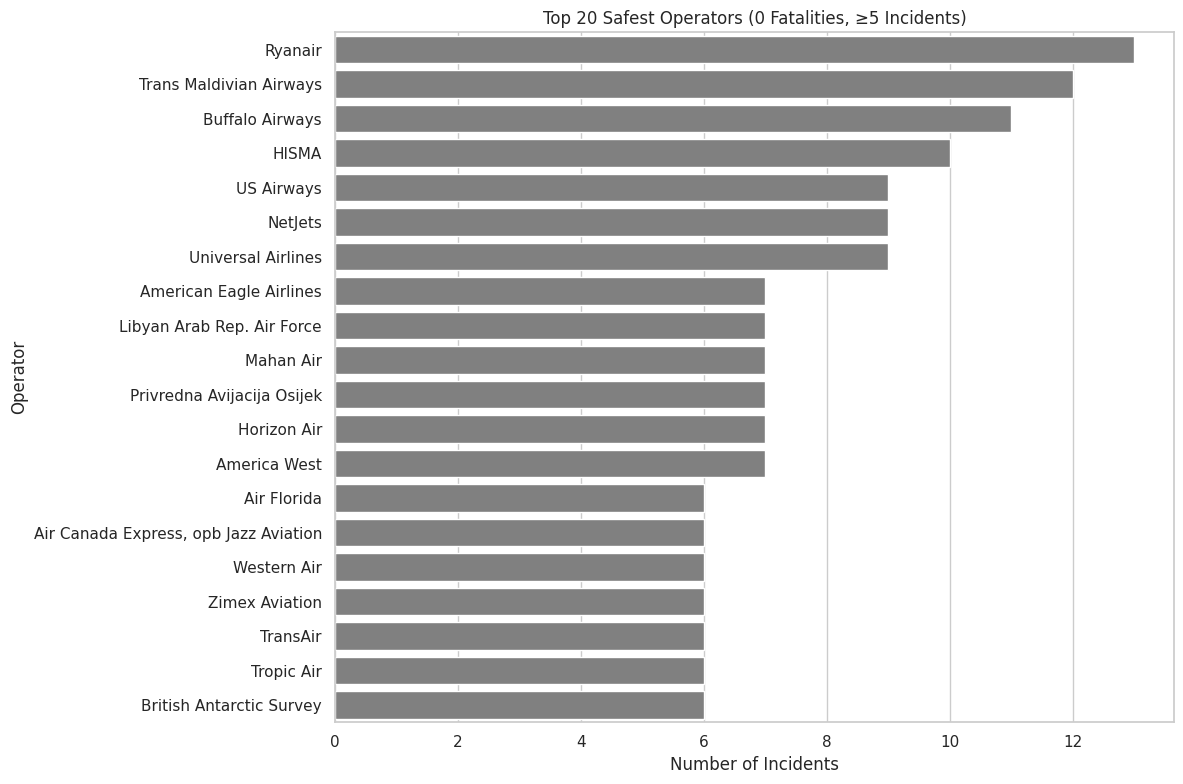

In [33]:
# Group by operator and calculate total number of incidents and total fatalities
safe_operators = df.groupby('operator').agg(
    incident_count=('operator', 'count'),
    total_fatalities=('fatalities', 'sum')
).reset_index()

# Filter: only operators with at least 5 incidents and 0 fatalities
safe_operators_filtered = safe_operators[
    (safe_operators['incident_count'] >= 5) & (safe_operators['total_fatalities'] == 0)
]

# Sort by number of incidents (descending) and select the top 20
top_safe = safe_operators_filtered.sort_values(by='incident_count', ascending=False).head(20)

# Horizontal bar plot
plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_safe,
    y='operator',
    x='incident_count',
    color='gray'
)

plt.title('Top 20 Safest Operators (0 Fatalities, ≥5 Incidents)')
plt.xlabel('Number of Incidents')
plt.ylabel('Operator')
plt.tight_layout()
plt.show()


### What Happened After September 11, 2001?

After September 11, 2001, the number of reported aviation incidents significantly decreased.  
This drop is likely due to the global reinforcement of aviation security measures, stricter regulatory frameworks, and enhanced monitoring systems introduced in the aftermath of the attacks.


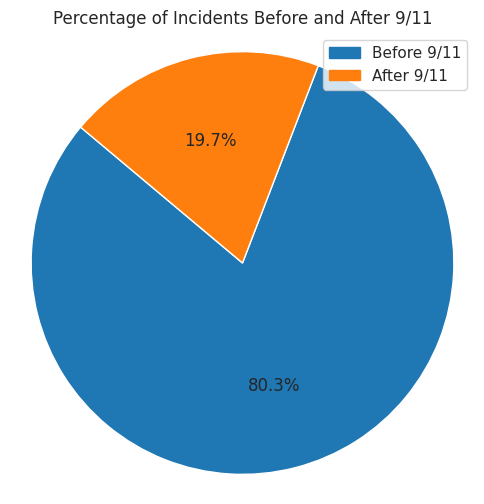

In [34]:
# Visualizing the proportion of incidents before and after September 11, 2001

sep11 = pd.to_datetime('2001-09-11')
before = df[df['date'] < sep11]
after = df[df['date'] >= sep11]

incident_count = [before.shape[0], after.shape[0]]
labels = ['Before 9/11', 'After 9/11']   #list with two values, the number of incidents after and befort 11/09
colors = ['#1f77b4', '#ff7f0e']

plt.figure(figsize=(6, 6))
plt.pie(incident_count, labels=None, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Percentage of Incidents Before and After 9/11')
plt.axis('equal')

patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(labels))]
plt.legend(handles=patches, loc='upper right')

plt.show()

In [35]:
# This line of code is used to check if there are any alternative spellings or versions of 'United States' in the 'country' column
# List all unique country names starting with 'U'
unique_countries = df['country'].dropna().unique()
countries_starting_with_u = sorted([
    country for country in unique_countries
    if str(country).strip().lower().startswith('u')
])

# Display result
for c in countries_starting_with_u:
    print(f"'{c}'")


'U.A.E.'
'U.K.'
'U.S. M.O. Islands'
'U.S. Virgin Isl.'
'USA'
'Uganda'
'Ukraine'
'Uruguay'
'Uzbekistan'


In [36]:
u_countries = df['country'].dropna().unique()
filtered = [c for c in u_countries if str(c).strip().lower().startswith('u')]
df[df['country'].isin(filtered)]['country'].value_counts()

,count
country,
USA,4377
U.K.,837
Ukraine,181
Uzbekistan,46
U.A.E.,35
U.S. Virgin Isl.,22
Uganda,20
Uruguay,20
U.S. M.O. Islands,12


In [37]:
usa_variants = [
    'USA', 'Usa', 'U.S.', 'US', 'United States of America',
    'United States ', 'U.S.A.', 'United States (Hawaii)',
    'U.S. Virgin Isl.', 'U.S. M.O. Islands', 'United States.'
]

In [38]:
df.loc[:, 'country'] = df['country'].replace(usa_variants, 'United States')

In [39]:
df['country'].value_counts().head(20)

,count
country,
United States,4411
Russia,1422
U.K.,837
Canada,826
India,700
Brazil,609
France,550
Germany,516
China,514


In [40]:


# Count incidents per country
country_counts = df['country'].value_counts().reset_index()
country_counts.columns = ['country', 'incident_count']

# Create choropleth map
fig = px.choropleth(country_counts,
                    locations="country",
                    locationmode="country names",
                    color="incident_count",
                    hover_name="country",
                    color_continuous_scale="Reds",
                    title="Global Distribution of Aviation Incidents (1919–2023)")

fig.show()


### Fixing the Choropleth Map: The Case of the United States

During the creation of the choropleth map representing the number of aviation incidents per country, an anomaly was observed: although the United States had the highest number of recorded incidents (over 4,000), its corresponding color on the map was not as dark as expected. This suggested a discrepancy in the data aggregation process.

#### The Problem

The issue stemmed from inconsistent naming conventions within the `country` column. Specifically:

- The United States appeared multiple times under different labels such as:
  - `"Usa"`
  - `"United States"`
  - `"U.S.A."`
  - `"U.S. Virgin Isl."` (technically a territory but still contributing to U.S. data)

Because of this, the choropleth map counted each variation as a separate country, thus **fragmenting the incident count** and preventing an accurate representation.

#### The Solution

To address this issue:

1. All alternative names and abbreviations referring to the United States were standardized to `"United States"`.
2. This cleaning step allowed for **accurate aggregation** of incidents associated with the U.S.
3. The choropleth map was regenerated, and the United States now correctly appears with the darkest shade, reflecting its true incident count.

This correction significantly improved the interpretability and reliability of the visualization.
